# Testing phase transition -- periodic Ring lattice

## Tome & Oliveira dynamics

### generating command lines

In [4]:
tTrans   = 10000
tTotal   = 30000
N = 5000

(tTotal - 2*tTrans) * N * 8 / 1024 / 1024

381.4697265625

In [8]:
import numpy

#cmd_to_generate = ['par','seq']
cmd_to_generate = ['seq']

cmd_line_seq = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.1 -sim timeevo -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_seq_timeevo.mat -update sequential -iterdynamics tome_oliveira'
cmd_line_par = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.0 -sim aval -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_par_aval.mat -update parallel -iterdynamics tome_oliveira'

N_values = [100,500,1000,2560,5000]
tTrans   = 10000
tTotal   = 30000

cmd_line_filename = f'lines_to_run_CP_phasetrans_ring_TO.sh'
out_dir           =  'test_sim/phase_trans_TO'

lmbda_values = numpy.linspace(1.0,4.5,100)

with open(cmd_line_filename,'w') as f:
    for N in N_values:
        if 'seq' in cmd_to_generate:
            for l in lmbda_values:
                f.write(cmd_line_seq.format(lmbda=l,N=N,tTrans=2*tTrans*N,tTotal=tTotal*N,out_dir=out_dir) + '\n')
            f.write('\n')
        if 'par' in cmd_to_generate:
            for l in lmbda_values:
                f.write(cmd_line_par.format(lmbda=l,N=N,tTrans=tTrans,tTotal=tTotal,out_dir=out_dir) + '\n')
            f.write('\n')
        f.write('\n')

### plotting phase transition

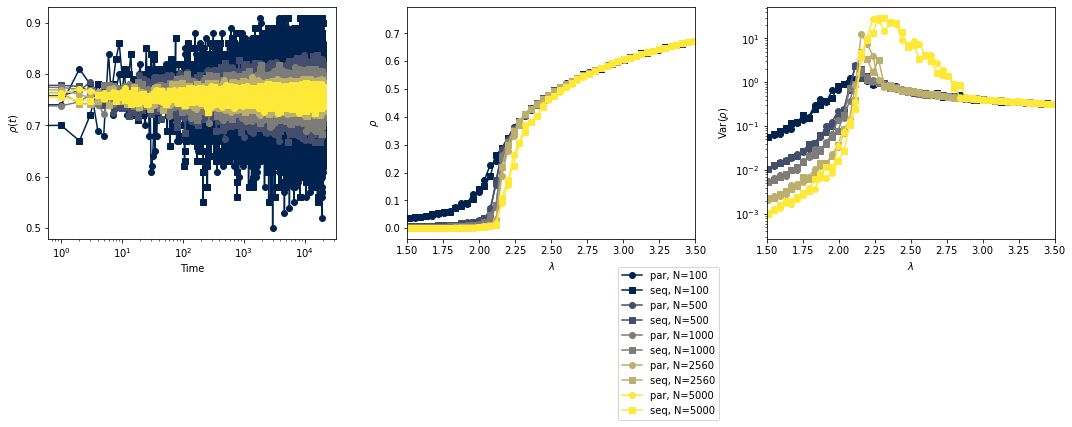

In [ ]:
import os
import glob
import numpy
import matplotlib.pyplot as plt
import modules.io as io

def calc_phasetrans_params(d):
    return d.l, numpy.nanmean(d.rho), float(d.N) * numpy.nanvar(d.rho)

def calc_phasetrans_params_struct(f_list):
    # returns lambda, <rho>, and susceptibility = N*var(rho)
    A = numpy.asarray(sorted([ calc_phasetrans_params(io.import_mat_file(f)) for f in f_list], key=lambda dd:dd[0]))
    return io.structtype(l=A[:,0],rho=A[:,1],suscept=A[:,2])

input_dir = ['test_sim/phase_trans_TO_old/N100/corr_ring',
             'test_sim/phase_trans_TO_old/N500/corr_ring',
             'test_sim/phase_trans_TO_old/N1000/corr_ring',
             'test_sim/phase_trans_TO_old/N2560/corr_ring',
             'test_sim/phase_trans_TO_old/N5000/corr_ring']

pt_par = [ sorted([ io.import_mat_file(f) for f in glob.glob(os.path.join(inpd,'*_par_*.mat'))], key=lambda dd:dd.l) for inpd in input_dir ]
pt_seq = [ sorted([ io.import_mat_file(f) for f in glob.glob(os.path.join(inpd,'*_seq_*.mat'))], key=lambda dd:dd.l) for inpd in input_dir ]


N_values     = numpy.array([ dd[0].N for dd in pt_par ])

l_values_par = [ numpy.array([            dd.l                     for dd in dN ]) for dN in pt_par ]
rho_par      = [ numpy.array([ numpy.nanmean(dd.rho)               for dd in dN ]) for dN in pt_par ]
rho_var_par  = [ numpy.array([ float(dd.N) * numpy.nanvar( dd.rho) for dd in dN ]) for dN in pt_par ]

l_values_seq = [ numpy.array([            dd.l                     for dd in dN ]) for dN in pt_seq ]
rho_seq      = [ numpy.array([ numpy.nanmean(dd.rho)               for dd in dN ]) for dN in pt_seq ]
rho_var_seq  = [ numpy.array([ float(dd.N) * numpy.nanvar( dd.rho) for dd in dN ]) for dN in pt_seq ]


colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))

ax[2].sharex(ax[1])

for k,N in enumerate(N_values):
    ax[0].plot(pt_par[k][-1].time                ,pt_par[k][-1].rho,'-o',label=f'par, N={N}',color=colors[k])
    ax[0].plot(pt_seq[k][-1].time/pt_seq[k][-1].dt,pt_seq[k][-1].rho,'-s',label=f'seq, N={N}',color=colors[k])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('$\\rho(t)$')
    ax[0].set_xscale('log')
    ax[1].plot(l_values_par[k],rho_par[k],'-o',label=f'par, N={N}',color=colors[k])
    ax[1].plot(l_values_seq[k],rho_seq[k],'-s',label=f'seq, N={N}',color=colors[k])
    ax[1].set_xlabel('$\\lambda$')
    ax[1].set_ylabel('$\\rho$')
    ax[2].plot(l_values_par[k],rho_var_par[k],'-o',label=f'par, N={N}',color=colors[k])
    ax[2].plot(l_values_seq[k],rho_var_seq[k],'-s',label=f'seq, N={N}',color=colors[k])
    ax[2].set_xlabel('$\\lambda$')
    ax[2].set_ylabel('Var($\\rho$)')
    ax[2].set_yscale('log')

ax[1].set_xlim((1.5,3.5))

plt.tight_layout()

ax[1].legend(bbox_to_anchor=(1.1,-0.1), loc='upper right')

plt.show()

### plotting phase transition Tome & Oliveira modified dynamics

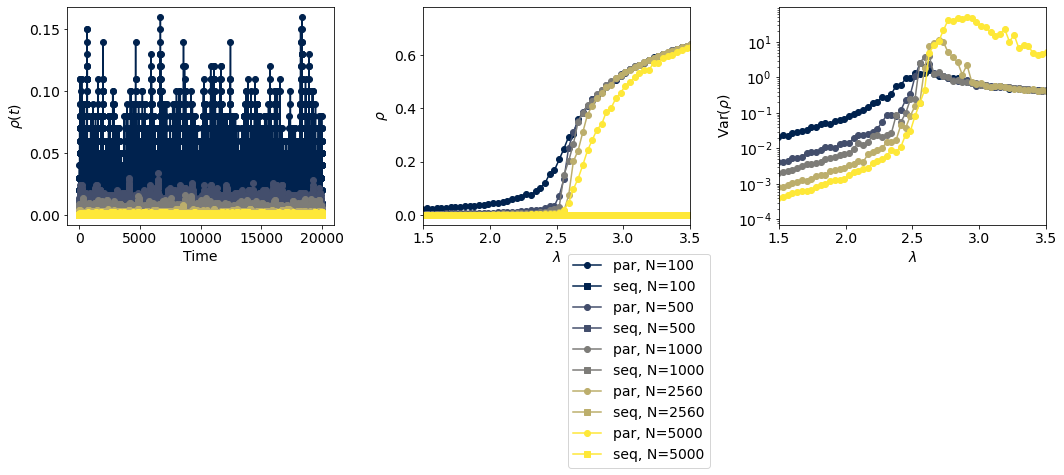

In [12]:
import os
import glob
import numpy
import matplotlib.pyplot as plt
import modules.phasetransdata as ptd

#data_to_plot = ['seq','par']
data_to_plot = ['par','seq']

input_dir = ['test_sim/phase_trans_TO/N100/corr_ring',
             'test_sim/phase_trans_TO/N500/corr_ring',
             'test_sim/phase_trans_TO/N1000/corr_ring',
             'test_sim/phase_trans_TO/N2560/corr_ring',
             'test_sim/phase_trans_TO/N5000/corr_ring']


if 'par' in data_to_plot:
    pt_par,d_par = ptd.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_par_*.mat')),k1=10000,k2=10000,return_file_data=True) for inpd in input_dir ])
if 'seq' in data_to_plot:
    pt_seq,d_seq = ptd.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_seq_*.mat')),k1=10000,k2=10000,return_file_data=True) for inpd in input_dir ])


N_values     = numpy.array(ptd.get_par_value_from_str(input_dir,'N')) #numpy.array([ dd[0].N for dd in d_par ])


colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))

ax[2].sharex(ax[1])

ind = 20

for k,N in enumerate(N_values):
    if 'par' in data_to_plot:
        if len(d_par):
            ax[0].plot(d_par[k][ind].time , d_par[k][ind].rho ,'-o',label=f'par, N={N}',color=colors[k])
        ax[1].plot(     pt_par[k].l      , pt_par[k].rho    ,'-o',label=f'par, N={N}',color=colors[k])
        ax[2].plot(     pt_par[k].l      , pt_par[k].suscept,'-o',label=f'par, N={N}',color=colors[k])
    if 'seq' in data_to_plot:
        if len(d_seq):
            ax[0].plot(d_seq[k][ind].time/d_seq[k][ind].dt , d_seq[k][ind].rho ,'-s',label=f'seq, N={N}',color=colors[k])
        ax[1].plot(    pt_seq[k].l                       , pt_seq[k].rho    ,'-s',label=f'seq, N={N}',color=colors[k])
        ax[2].plot(    pt_seq[k].l                       , pt_seq[k].suscept,'-s',label=f'seq, N={N}',color=colors[k])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('$\\rho(t)$')
    #ax[0].set_xscale('log')
    #ax[0].set_yscale('log')
    ax[1].set_xlabel('$\\lambda$')
    ax[1].set_ylabel('$\\rho$')
    ax[2].set_xlabel('$\\lambda$')
    ax[2].set_ylabel('Var($\\rho$)')
    ax[2].set_yscale('log')

ax[1].set_xlim((1.5,3.5))

plt.tight_layout()

ax[1].legend(bbox_to_anchor=(1.1,-0.1), loc='upper right')

plt.show()


## Marro & Dickman dynamics

### generating command lines

In [7]:
import numpy

#cmd_to_generate = ['par','seq']
cmd_to_generate = ['seq']

cmd_line_seq = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.1 -sim timeevo -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_seq_timeevo.mat -update sequential -iterdynamics marro_dickman'
cmd_line_par = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.0 -sim aval -outputFile {out_dir:s}/N{N:d}/corr_ring/cp_ring_N{N:d}_l{lmbda:g}_par_aval.mat -update parallel -iterdynamics marro_dickman'

N_values = [100,500,1000,2560,5000]
tTrans   = 10000
tTotal   = 30000

cmd_line_filename = f'lines_to_run_CP_phasetrans_ring_MD.sh'
out_dir           =  'test_sim/phase_trans_MD'

lmbda_values = numpy.linspace(1.0,4.5,100)

with open(cmd_line_filename,'w') as f:
    for N in N_values:
        if 'seq' in cmd_to_generate:
            for l in lmbda_values:
                f.write(cmd_line_seq.format(lmbda=l,N=N,tTrans=2*tTrans*N,tTotal=tTotal*N,out_dir=out_dir) + '\n')
            f.write('\n')
        if 'par' in cmd_to_generate:
            for l in lmbda_values:
                f.write(cmd_line_par.format(lmbda=l,N=N,tTrans=tTrans,tTotal=tTotal,out_dir=out_dir) + '\n')
            f.write('\n')
        f.write('\n')

### plotting phase transition

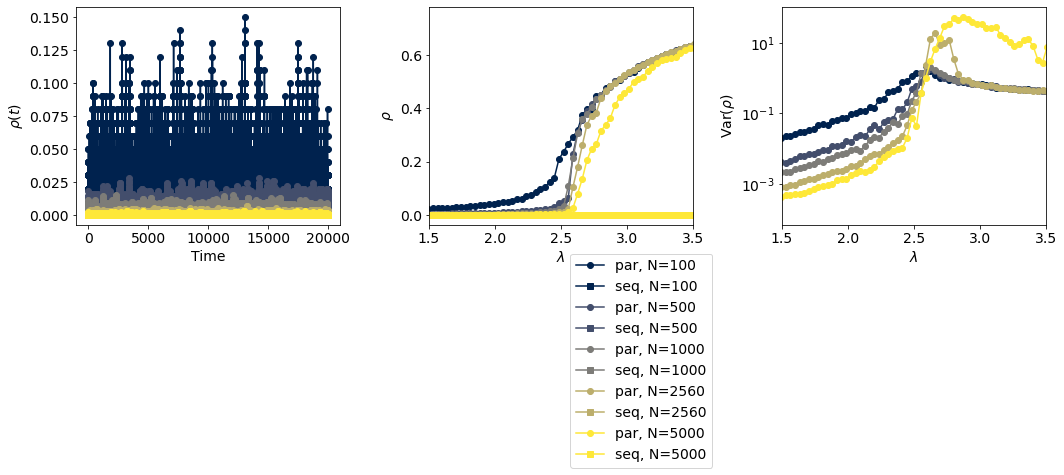

In [11]:
import os
import glob
import numpy
import matplotlib.pyplot as plt
import modules.phasetransdata as ptd

data_to_plot = ['seq','par']
#data_to_plot = ['par']

input_dir = ['test_sim/phase_trans_MD/N100/corr_ring',
             'test_sim/phase_trans_MD/N500/corr_ring',
             'test_sim/phase_trans_MD/N1000/corr_ring',
             'test_sim/phase_trans_MD/N2560/corr_ring',
             'test_sim/phase_trans_MD/N5000/corr_ring']

if 'par' in data_to_plot:
    pt_par,d_par = ptd.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_par_*.mat')),k1=10000,k2=10000,return_file_data=True) for inpd in input_dir ])
if 'seq' in data_to_plot:
    pt_seq,d_seq = ptd.unpack_list_of_tuples([ ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_seq_*.mat')),k1=10000,k2=10000,return_file_data=True) for inpd in input_dir ])


N_values     = numpy.array(ptd.get_par_value_from_str(input_dir,'N')) #numpy.array([ dd[0].N for dd in d_par ])


colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))

ax[2].sharex(ax[1])

for k,N in enumerate(N_values):
    if 'par' in data_to_plot:
        if len(d_par):
            ax[0].plot(d_par[k][ind].time , d_par[k][ind].rho ,'-o',label=f'par, N={N}',color=colors[k])
        ax[1].plot(     pt_par[k].l      , pt_par[k].rho    ,'-o',label=f'par, N={N}',color=colors[k])
        ax[2].plot(     pt_par[k].l      , pt_par[k].suscept,'-o',label=f'par, N={N}',color=colors[k])
    if 'seq' in data_to_plot:
        if len(d_seq):
            ax[0].plot(d_seq[k][ind].time/d_seq[k][ind].dt , d_seq[k][ind].rho ,'-s',label=f'seq, N={N}',color=colors[k])
        ax[1].plot(    pt_seq[k].l                       , pt_seq[k].rho    ,'-s',label=f'seq, N={N}',color=colors[k])
        ax[2].plot(    pt_seq[k].l                       , pt_seq[k].suscept,'-s',label=f'seq, N={N}',color=colors[k])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('$\\rho(t)$')
    #ax[0].set_xscale('log')
    #ax[0].set_yscale('log')
    ax[1].set_xlabel('$\\lambda$')
    ax[1].set_ylabel('$\\rho$')
    ax[2].set_xlabel('$\\lambda$')
    ax[2].set_ylabel('Var($\\rho$)')
    ax[2].set_yscale('log')

ax[1].set_xlim((1.5,3.5))

plt.tight_layout()

ax[1].legend(bbox_to_anchor=(1.1,-0.1), loc='upper right')

plt.show()